# All kinds of network things 

In [9]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import regex as re 
from os import listdir
from os.path import isfile, join
import json 
# get files in directory 
onlyfiles = [f for f in listdir("wiki_content") if isfile(join("wiki_content", f))]

In [10]:
''' Extract links '''
theo_dict  = {}
for file in onlyfiles:
    with open(f'wiki_content/{file}','r', encoding = 'utf-8') as f:
        txt = f.read()
        links = re.findall('\[\[(.*?)(?:\|.*?)?]]', txt)
        name = file.split('.txt')[0].replace('_',' ')
        theo_dict.update({name:links}) 

In [11]:
''' Hvordan linker de til hinanden '''
# Sætter .replace('_', ' ') på name, for at have styr på fx 'Anselm_Strauss' links 
link_dict = {theorist:[_name.replace('_', ' ') for _name in links if _name.replace('_', ' ') in theo_dict.keys()]\
             for theorist, links in theo_dict.items()}

''' Link list '''
link_list = [(node_a, node_b) for node_a, nodes in link_dict.items() for node_b in nodes]

In [12]:
''' Get science attribute '''

with open('science_name_dict.json', 'r', encoding = 'utf-8') as f: 
    science_dict = json.load(f)
    
''' Get those that are in multiple scientific field lists - Marx is in both... '''

socs = set(science_dict['soc'])
anths = set(science_dict['anth'])
ecos = set(science_dict['eco'])
psys = set(science_dict['psy'])
pols = set(science_dict['pol'])

seen = []
repeated = []
for l in [socs, anths, ecos, psys, pols]:
    for i in l: # loop over de enkelte guys'n'gals
        if i in seen:
            repeated.append(i)
        else:
            seen.append(i)

''' Inverse the dict '''
inv_science_dict = {name:science for science, names in science_dict.items() for name in names}
''' change the scientific field to "both" if they are both in the soc and anth list '''
inv_science_dict = {name:('multiple' if name in repeated else sci)\
                    for name, sci in inv_science_dict.items()}

# Match keys to link_dict --> when importing link_dict, 'Anselm_Strauss' becomes 'Anselm Strauss'
# but in the inv_science_dict he is 'Anselm_Strauss'. So it is a mess without it   
inv_science_dict = {key.replace('_', ' '):val for key, val in inv_science_dict.items()}

with open('inv_science_name_dict.json', 'w', encoding = 'utf-8') as f: 
    json.dump(inv_science_dict, f)

In [13]:
''' Make network '''
import networkx as nx
import netwulf as nw
G = nx.DiGraph()
G.add_nodes_from(link_dict.keys())
G.add_edges_from(link_list)
nx.set_node_attributes(G, inv_science_dict, name = 'group') # node attributes 

In [14]:
''' Plot network '''
import matplotlib.pylab as plt
%matplotlib inline
plt.style.use('seaborn-white')

network, config = nw.visualize(G, plot_in_cell_below=False)

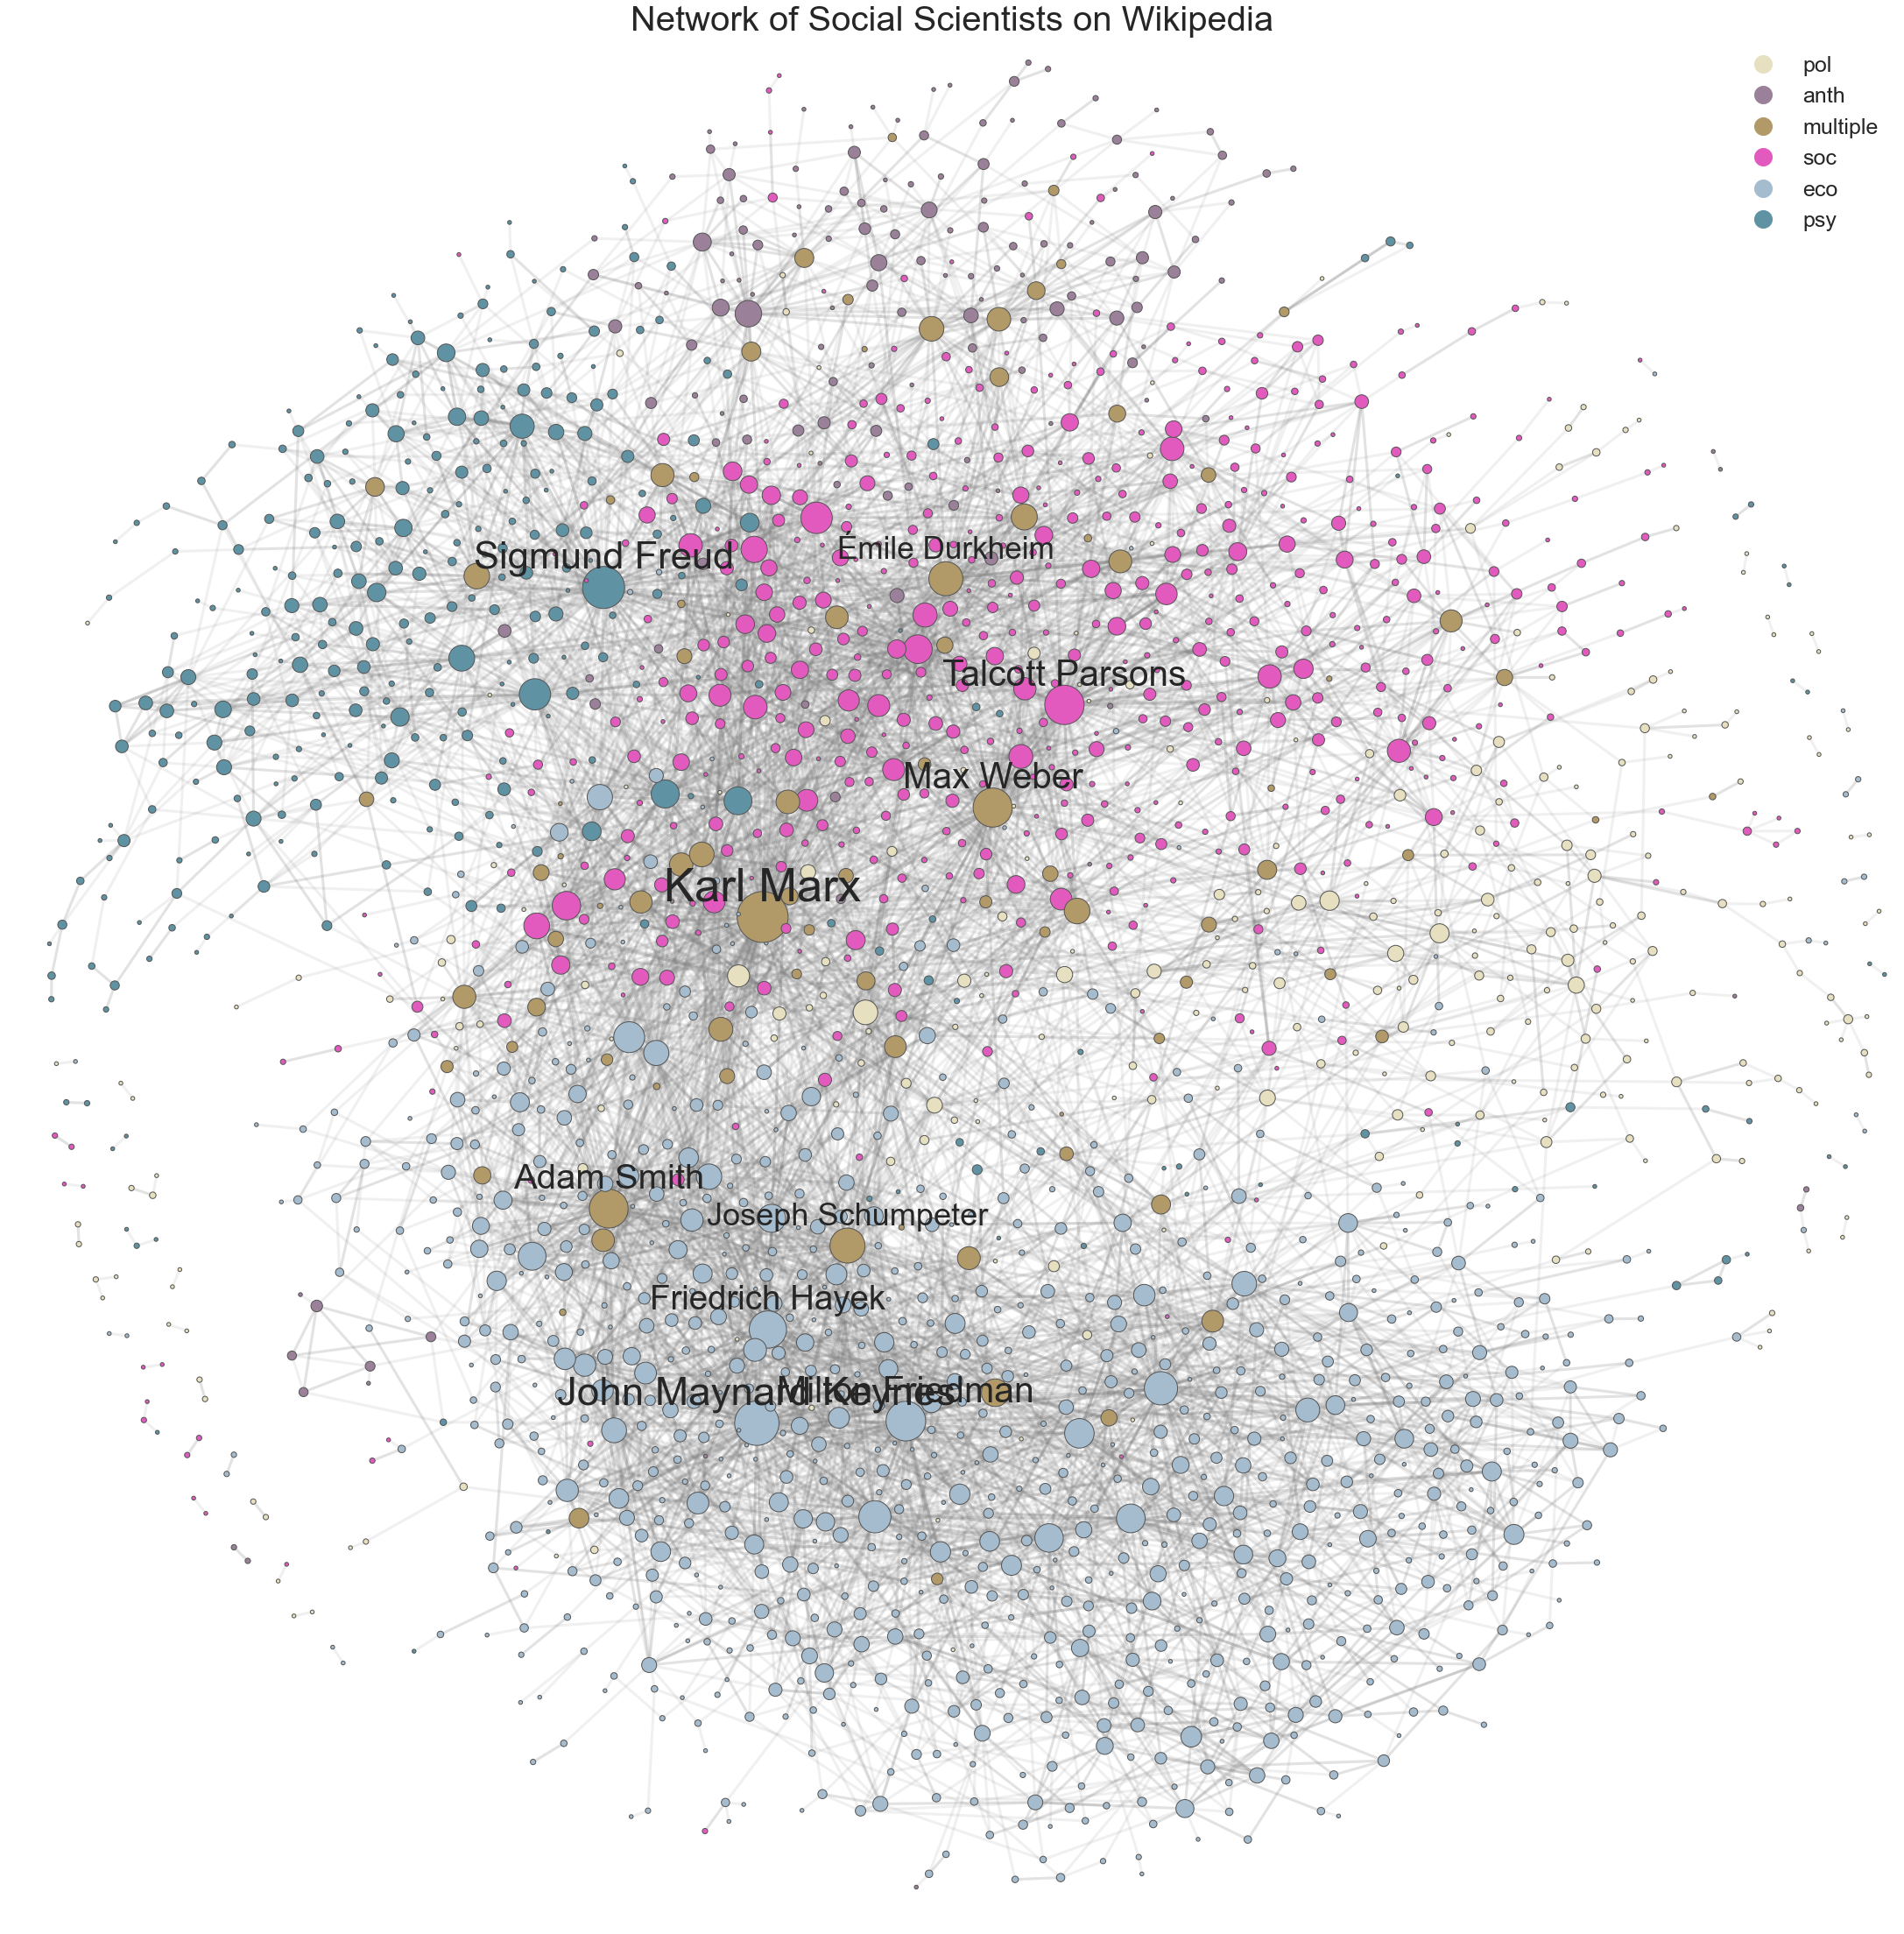

In [20]:
# Drawing the network
fig, ax = nw.draw_netwulf(network)

# assigning labels only to the largest nodes 
for node_nr in range(len(network['nodes'])):
    if network['nodes'][node_nr]['radius']>7:
        nw.tools.add_node_label(ax,
                                network,
                                dy = 12,
                                node_id = network['nodes'][node_nr]['id'],
                                size=network['nodes'][node_nr]['radius']*5)
    else:
        pass

# Drawing a big figure
plt.rcParams["figure.figsize"] = (30,30)

val_map = {inv_science_dict[node['id']]:node['color'] for node in network['nodes']}

# Add legends
for label in val_map.keys():
    ax.plot([],[],color=val_map[label], label=label, marker='o', linestyle="None", markersize = 20)

plt.legend(fontsize = 25)
ax.set_title('Network of Social Scientists on Wikipedia', size = 40)
# Saving as pdf
plt.savefig('Plots/field_network_title.png', dpi=None, facecolor='w', edgecolor='w', bbox_inches='tight')

In [21]:
''' Save the network configurations '''
with open("network_configurations/big_network.json", 'w') as f:
    json.dump(network, f)
    
with open("network_configurations/big_config.json", 'w') as f:
    json.dump(config, f)

In [22]:
''' load the network configurations '''
with open("network_configurations/big_network.json", 'r') as f:
    network = json.load(f)

with open("network_configurations/big_config.json", 'r') as f:
    config = json.load(f)

In [23]:
''' Recolor nodes based on a partition dictionary and colormap 
    Only works if all nodes in nx_configs are in partition_dict as well '''
def redefine_attr(nx_configs, partition_dict, _cmap = plt.cm.Spectral_r):
    import copy
    import matplotlib

    _keys = set(partition_dict.values()) # the attribute classes
    n_keys = len(_keys) # how many are there? how many colors do we need?
    # assign each attribute class a unique value between 0 and 1
    # _num/(n_keys-1) --> standarize score with 0 and 1 as min and max
    attr_scale_dict = {_cat:_num/(n_keys-1) for _cat, _num in zip(_keys, range(n_keys))}
    
    # Copy dict - deep copy as the values are nested in a list
    new_nw = copy.deepcopy(nx_configs)
    
    for node_nr in range(len(nx_configs['nodes'])):
        node = network['nodes'][node_nr]['id'] # node id 
        attr = partition_dict[node] # get the attribute class of the node
        num_attr = attr_scale_dict[attr] # get the numerical 
        _cmap_color = _cmap(num_attr)
        # overwrite node color based on new attr
        new_nw['nodes'][node_nr]['color'] = matplotlib.colors.rgb2hex(_cmap_color) 
        
    return new_nw

In [25]:
the_output = redefine_attr(network, inv_science_dict)

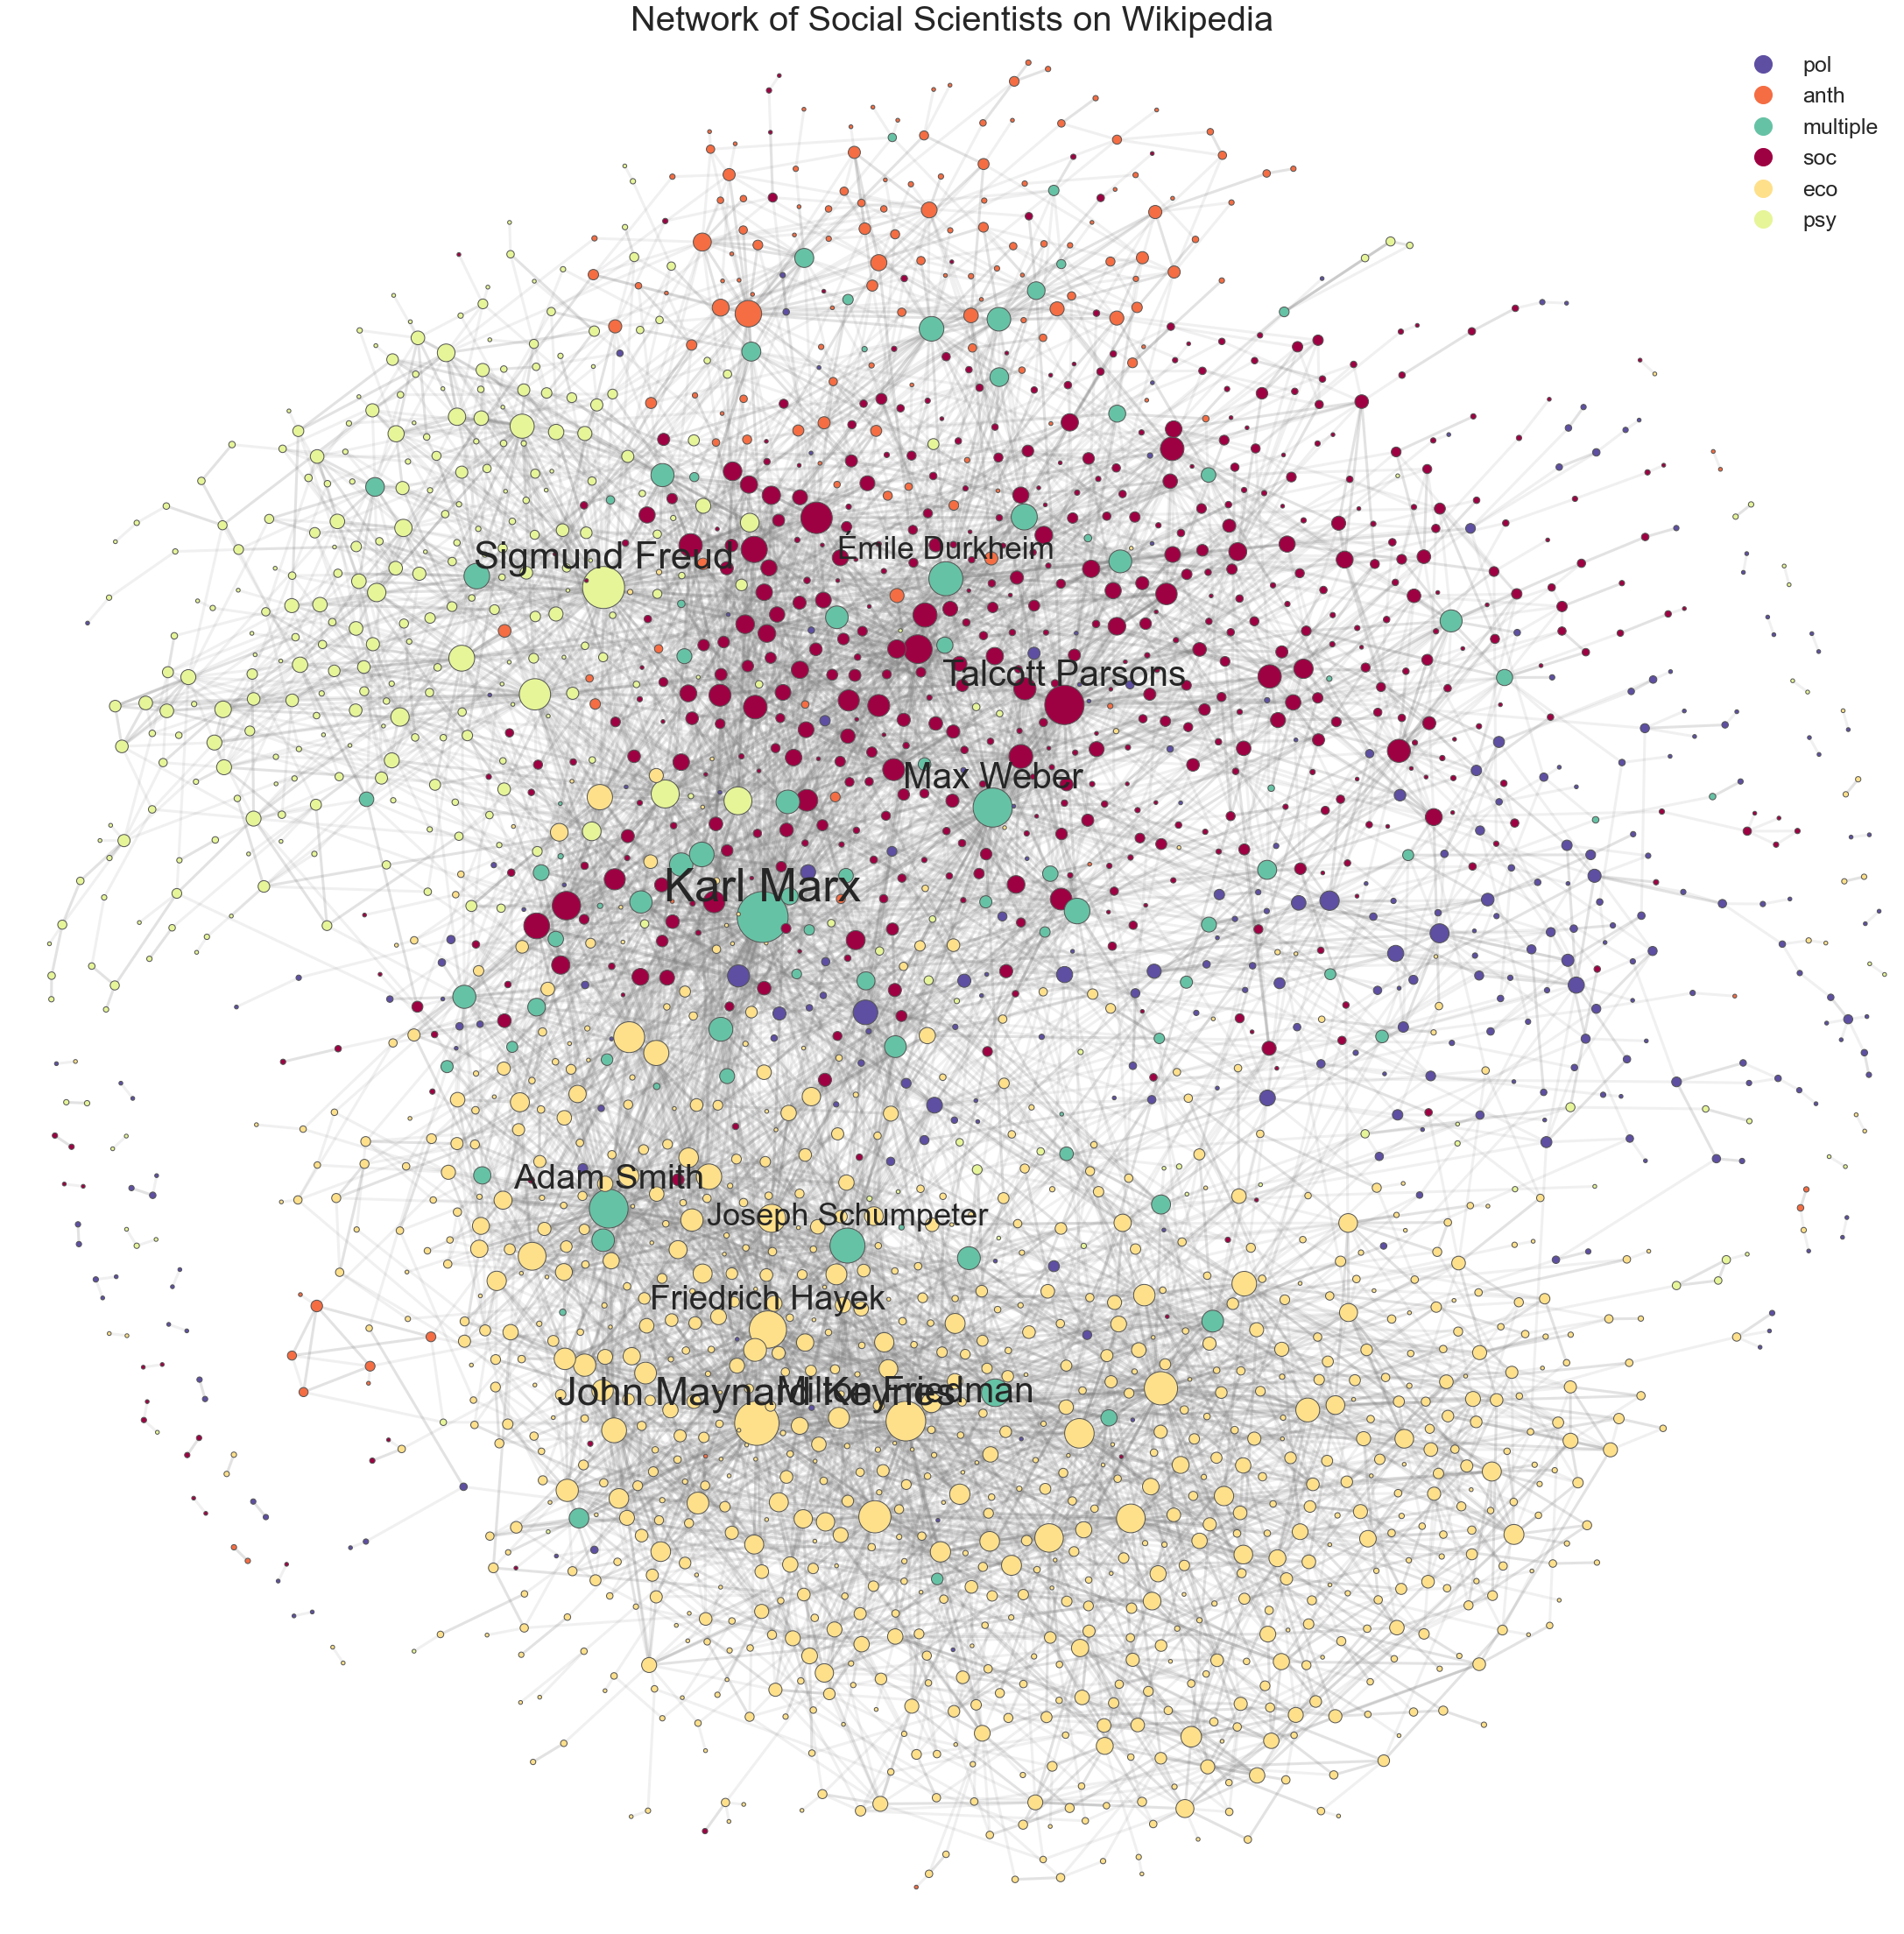

In [27]:
# Drawing the network
fig, ax = nw.draw_netwulf(the_output)

# assigning labels only to the largest nodes 
for node_nr in range(len(the_output['nodes'])):
    if network['nodes'][node_nr]['radius']>7:
        nw.tools.add_node_label(ax,
                                the_output,
                                dy = 12,
                                node_id = the_output['nodes'][node_nr]['id'],
                                size=the_output['nodes'][node_nr]['radius']*5)
    else:
        pass

# Drawing a big figure
plt.rcParams["figure.figsize"] = (30,30)

val_map = {inv_science_dict[node['id']]:node['color'] for node in the_output['nodes']}

# Add legends
for label in val_map.keys():
    ax.plot([],[],color=val_map[label], label=label, marker='o', linestyle="None", markersize = 20)

plt.legend(fontsize = 25)
ax.set_title('Network of Social Scientists on Wikipedia', size = 40)
# Saving as pdf
plt.savefig('Plots/field_network_title.png', dpi=None, facecolor='w', edgecolor='w', bbox_inches='tight')

In [34]:
import matplotlib.pylab as plt
%matplotlib inline
plt.style.use('seaborn-white')

''' Degree distribution '''
def plot_deg_dist(deg_seq, title = 'Degree distribution', save_title = "", kwgs = {}):
    plt.style.use('ggplot')
    
    fig, ax = plt.subplots(2,1, figsize=(10,8))
    
    sns.scatterplot(x=deg_seq.keys(), y=deg_seq.values(), ax = ax[0], **kwgs)
    ax[0].set_title(title)
    ax[0].set_ylabel('Frequency', size = 15)
    
    del deg_seq[0] # messes up the log plot so remove 0 deg nodes 
    sns.scatterplot(x=deg_seq.keys(), y=deg_seq.values(), ax = ax[1], **kwgs)

    ax[1].set_title(title + ' (log scaled)')
    ax[1].set_ylabel('Frequency', size = 15)
    ax[1].set_xlabel('k', size = 15)
    # logscale the axes
    ax[1].set_yscale('log')
    ax[1].set_xscale('log')
    
    # Saving as pdf
    plt.savefig(f'Plots/{save_title}.png', dpi=200, facecolor='w', edgecolor='w', bbox_inches='tight')
    plt.show()

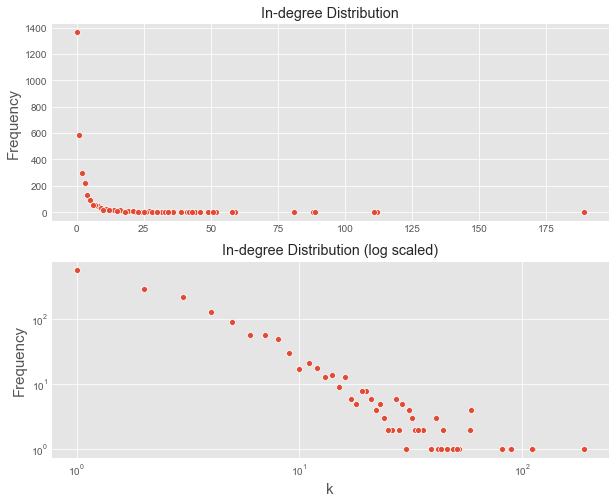

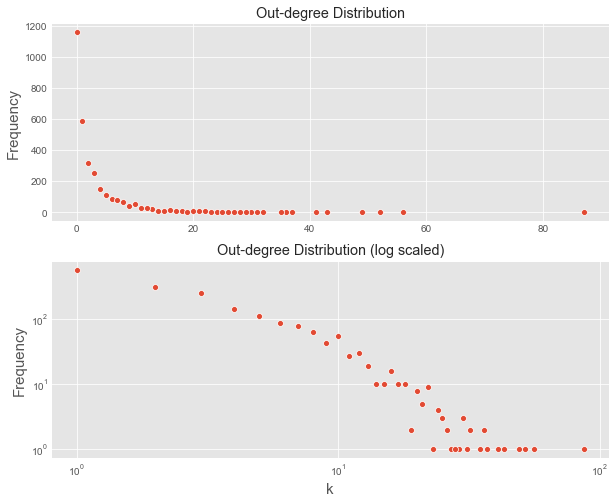

In [35]:
''' Plot degree distribution '''
import seaborn as sns
from collections import Counter

# Get in and out degree
in_deg_dist = Counter([d for n,d in G.in_degree()])
out_deg_dist = Counter([d for n,d in G.out_degree()])

# Plot and save 
plot_deg_dist(in_deg_dist, 'In-degree Distribution', save_title="in_deg_dist")
plot_deg_dist(out_deg_dist, 'Out-degree Distribution', save_title= "out_deg_dist")

In [36]:
''' Plot the top X out- and in- degree nodes '''
def plot_top_nodes(top_n = 50, in_deg = True, save_title = ""):
    if in_deg:
        top_nodes = sorted(dict(G.in_degree()).items(), key = lambda x: x[1], reverse = True)[:top_n]
    else:
        top_nodes = sorted(dict(G.out_degree()).items(), key = lambda x: x[1], reverse = True)[:top_n]
    x = [_[0] for _ in top_nodes]
    y = [_[1] for _ in top_nodes]

    fig, ax = plt.subplots(figsize = (12,6))
    sns.scatterplot(x,y, ax=ax)
    ax.set_ylabel('Degree', size = 15)
    plt.xticks(rotation=90, size = 12)
    if in_deg:
        ax.set_title(f'Distribution of in-degree for top {top_n}', size = 15)
    else:
        ax.set_title(f'Distribution of out-degree for top {top_n}', size = 15)
        
    # Saving as pdf
    plt.savefig(f'Plots/{save_title}.png', dpi=200, facecolor='w', edgecolor='w', bbox_inches='tight')
    
    plt.show()

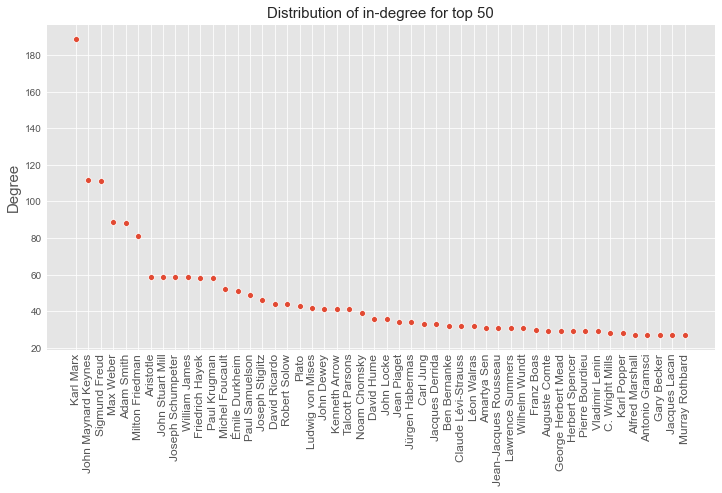

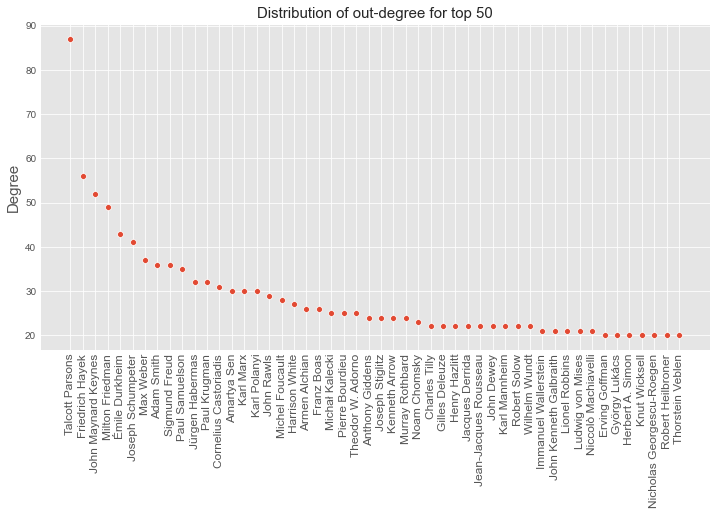

In [37]:
plot_top_nodes(in_deg = True, save_title="top_in_deg")
plot_top_nodes(in_deg = False, save_title="top_out_deg")

# Communities 

In [38]:
import community
from fa2 import ForceAtlas2

In [39]:
''' Only the GCC, otherwise there will be about 300+ communities '''
G_test = G.copy()
c = max(nx.weakly_connected_components(G_test), key=len) # largest connected component
GCC = G_test.subgraph(c).copy() # make subgraph of the largest connected component
G_undir = GCC.to_undirected().copy() # undirected

# Louvain modularity for partition
partition = community.best_partition(G_undir, random_state = 280395)

In [40]:
# Dict with name as key and field and community dicts as values 
joined_dict = {name:{'field':inv_science_dict[name], 'community':com}\
               for name, com in partition.items()}

with open('name_field_community.json', 'w', encoding = 'utf-8') as f: 
    json.dump(joined_dict, f)

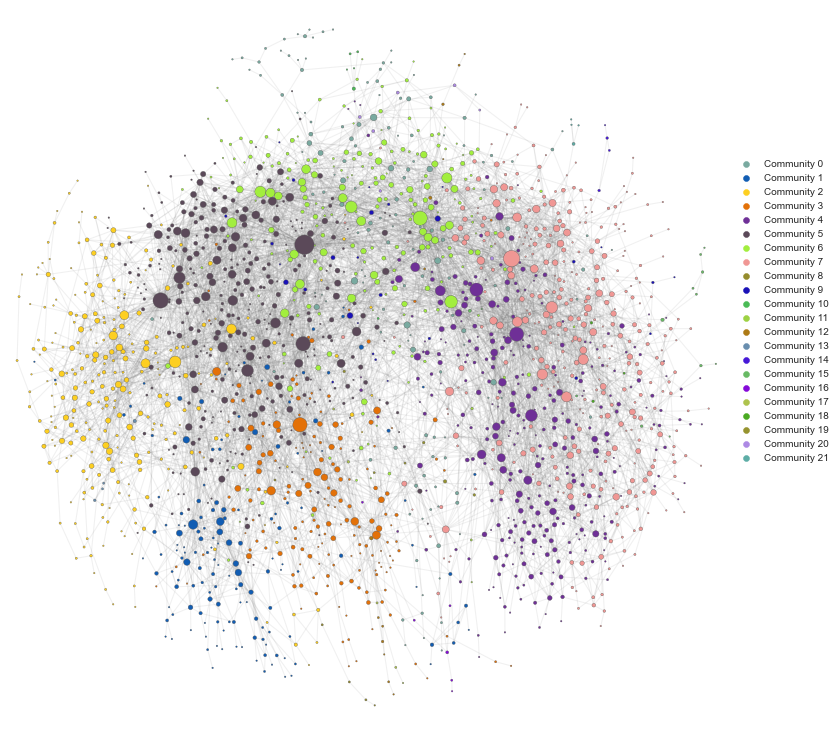

In [41]:
''' Plot community partition '''
nx.set_node_attributes(G_undir, partition, name = 'group') # node attributes 
## Use the configs from the big non-GCC network
network_part, config_part = nw.visualize(G_undir, plot_in_cell_below=False, config = config)

fig, ax = nw.draw_netwulf(network_part, figsize = 10)

# {community:color} dict for the legend
val_map = {partition[node['id']]:node['color'] for node in network_part['nodes']}

# Add legends
for v in sorted(val_map.keys()):
    plt.scatter([],[],color=val_map[v], 
                label='Community {}'.format(v), 
                marker='o',
                linestyle="None")
# Place legend
plt.legend(bbox_to_anchor = (1,0.8))
# Saving as pdf
fig.savefig(f'Plots/community_network.png', dpi=200, facecolor='w', edgecolor='w', bbox_inches='tight')

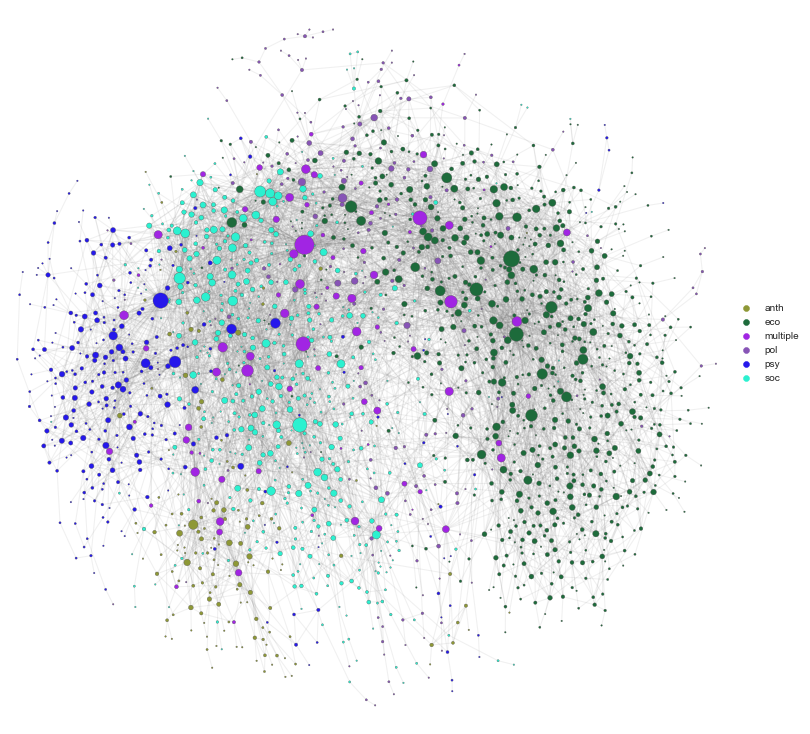

In [44]:
''' Plot community partition '''
nx.set_node_attributes(G_undir, inv_science_dict, name = 'group') # node attributes 
## Use the configs from the big non-GCC network
network_part, config_part = nw.visualize(G_undir, plot_in_cell_below=False, config = config)

fig, ax = nw.draw_netwulf(network_part, figsize = 10)

# {community:color} dict for the legend
val_map = {inv_science_dict[node['id']]:node['color'] for node in network_part['nodes']}

# Add legends
for v in sorted(val_map.keys()):
    plt.scatter([],[],color=val_map[v], 
                label=v, 
                marker='o',
                linestyle="None")
# Place legend
plt.legend(bbox_to_anchor = (1,0.6))
fig.savefig(f'Plots/gcc_network.png', dpi=200, facecolor='w', edgecolor='w', bbox_inches='tight')

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:01<00:00, 16.19it/s]


BarnesHut Approximation  took  9.14  seconds
Repulsion forces  took  50.69  seconds
Gravitational forces  took  0.17  seconds
Attraction forces  took  0.09  seconds
AdjustSpeedAndApplyForces step  took  0.68  seconds


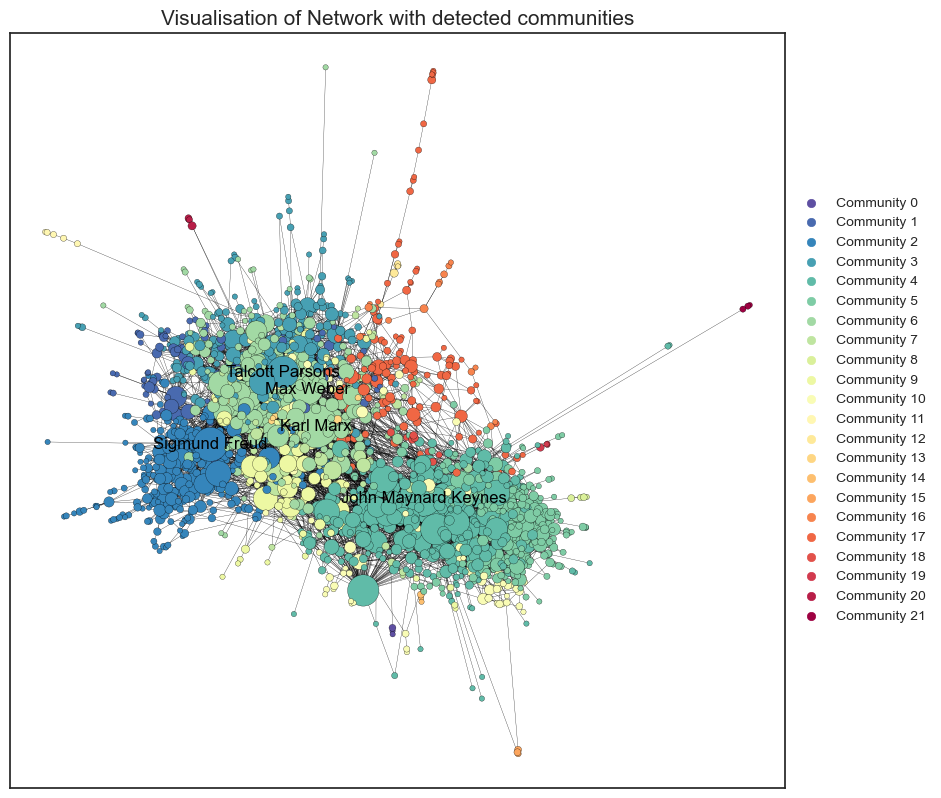

In [21]:
plt.style.use('seaborn-white')
# Get forceatlas positions
_pos = ForceAtlas2(outboundAttractionDistribution=True,
                   gravity=0.1,
                   verbose=True)\
       .forceatlas2_networkx_layout(G_undir, pos=None, iterations=1000)

# Get colors - use the value of the community 
c_values = list(partition.values())
# degree dict - scale node size
_d = dict(G_undir.degree) 

fig, ax = plt.subplots(dpi = 100, figsize = (10,10))

# Plot parameteres
_ks = {"node_color":c_values,
       "cmap": plt.cm.Spectral_r,
       "node_size":[10 + v*5 for v in _d.values()],
       "pos":_pos,
       "ax":ax,
       "with_labels":False,
       "edgecolors": 'black',
       "linewidths": 0.2,
       "width":0.2
       }

ax.set_title('Visualisation of Network with detected communities', size = 15)

# Set community legend
for v in set(c_values):
    plt.scatter([],[], c=[plt.cm.Spectral_r(v/max(c_values))], label='Community {}'.format(v))
    
# Place legend
plt.legend(bbox_to_anchor = (1,0.8))

nx.draw_networkx(G_undir, **_ks)

# Get top n connected nodes
top_n = 5
top_nodes = [x[0] for x in sorted(dict(G_undir.degree()).items(), key = lambda x: x[1], reverse = True)[:top_n]]

labels = {}    
for node in G_undir.nodes():
    if node in  top_nodes:
        #set the node name as the key and the label as its value 
        labels[node] = node
        
nx.draw_networkx_labels(G_undir,_pos,labels,font_size=12,font_color='black')

plt.show()

In [55]:
fig.savefig('community_detection.png', dpi=300, bbox_inches='tight')

In [28]:
def _field_plt(_n=5):
    plt.style.use('seaborn-white')
    val_map = {'soc':"#6666ff",
               'anth':"#33cc33",
               'multiple':"#ff9966",
               'pol':"#ff4d4d",
               'psy': '#ff4dff',
               'eco': '#4dd2ff'}

    # Get colors - use the value of the community 
    c_values = [val_map[inv_science_dict[n]] for n in G_undir.nodes()]

    list(partition.values())
    # degree dict - scale node size
    _d = dict(G_undir.degree) 

    fig, ax = plt.subplots(dpi = 100, figsize = (10,10))

    # Plot parameteres
    _ks = {"node_color":c_values,
           "cmap": plt.cm.Spectral_r,
           "node_size":[10 + v*5 for v in _d.values()],
           "pos":_pos,
           "ax":ax,
           "with_labels":False,
           "edgecolors": 'black',
           "linewidths": 0.2,
           "width":0.2
           }

    ax.set_title('Visualisation of Network with Scientific Fields', size = 15)

    # Add legends
    for label in val_map.keys():
        ax.plot([],[],color=val_map[label], label=label, marker='o', linestyle="None")

    # Place legend
    plt.legend(bbox_to_anchor = (1,0.8))

    nx.draw_networkx(G_undir, **_ks)
    
    # Get top n connected nodes
    top_n = _n
    top_nodes = [x[0] for x in sorted(dict(G_undir.degree()).items(), key = lambda x: x[1], reverse = True)[:top_n]]

    labels = {}    
    for node in G_undir.nodes():
        if node in  top_nodes:
            #set the node name as the key and the label as its value 
            labels[node] = node
            
    nx.draw_networkx_labels(G_undir,_pos,labels,font_size=12,font_color='black')
    plt.show()

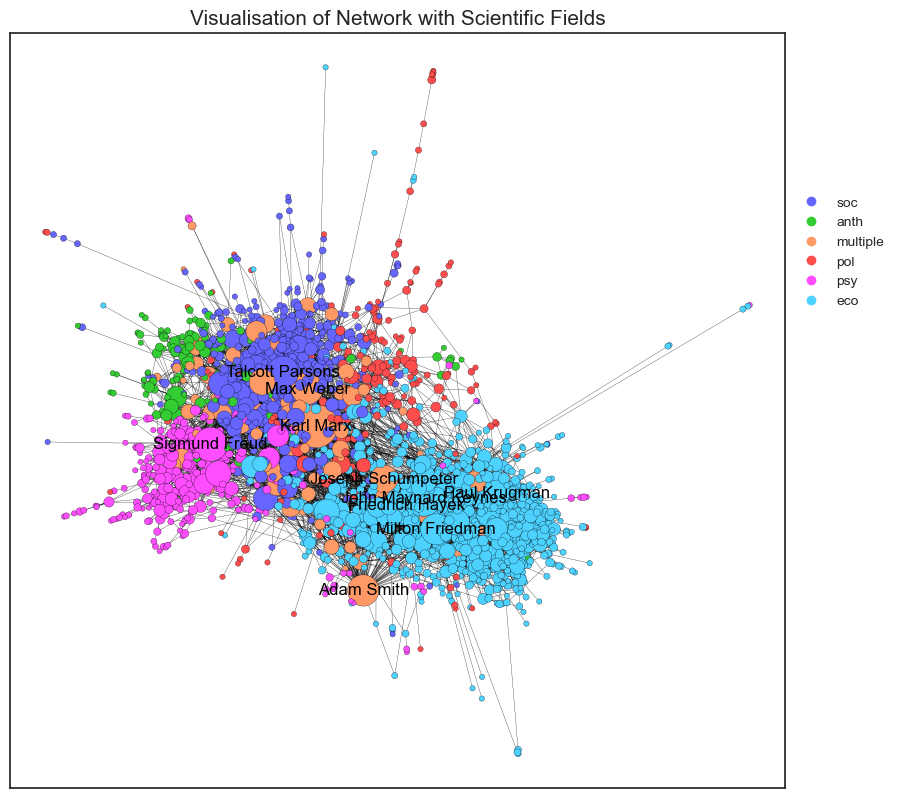

In [29]:
_field_plt(_n=10)

prøv https://github.com/beyondbeneath/bezier-curved-edges-networkx